# Problem 1: Segmentation


In [ ]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils import data
from torchvision import transforms as T
from torchvision import models
from google.colab import drive

drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/COMP447/"

torch.manual_seed(0)
np.random.seed(0)

Mounted at /content/drive


In [ ]:
!gdown https://drive.google.com/uc?id=1eYYJ26R1S9Ln_ExwHFBqd3rbln9qVdi4&export=download
!unzip -qq cityscapes.zip

Downloading...
From (original): https://drive.google.com/uc?id=1eYYJ26R1S9Ln_ExwHFBqd3rbln9qVdi4
From (redirected): https://drive.google.com/uc?id=1eYYJ26R1S9Ln_ExwHFBqd3rbln9qVdi4&confirm=t&uuid=780276a2-bae3-4e1d-b550-08dfaf1da5bf
To: /content/cityscapes.zip
100% 651M/651M [00:11<00:00, 55.1MB/s]


In [ ]:
class Segmenter(torch.nn.Module):
    def __init__(self, n_classes, encoder):
        super(Segmenter, self).__init__()
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels=64, out_channels=n_classes, kernel_size=3, padding=1)
        )

    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x # Your code for Problem 1a goes here

In [ ]:
class CityScapesDataset(Dataset):
  def __init__(self, images, labels, im_transform, mask_transform):
    self.images = images
    self.labels = labels
    self.im_transform = im_transform
    self.mask_transform = mask_transform

  def __getitem__(self, idx):
    im = Image.open(self.images[idx])
    mask = Image.open(self.labels[idx])
    im = self.im_transform(im)[0:3, ...] # Transform image

    # Add an extra first dimension to mask (needed for transforms), convert
    # to LongTensor b/c values are integers, and apply transforms.
    mask = np.asarray(mask)[None, ...]
    mask = torch.LongTensor(mask)
    mask = self.mask_transform(mask)

    # Apply random horizontal flip to image and mask
    if np.random.rand() > 0.5:
      im = TF.hflip(im)
      mask  = TF.hflip(mask)

    return im, mask

  def __len__(self):
    return len(self.images)

In [ ]:
batch_size = 16

# Make image and mask transforms.
im_transform = [T.ToTensor()]
im_transform.append(T.Resize((256, 256), interpolation=T.InterpolationMode.BILINEAR))
im_transform = T.Compose(im_transform)

mask_transform = T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST)

def get_dataloader(im_path):
  images = sorted(glob.glob(im_path + '/*8bit.jpg'))
  labels = sorted(glob.glob(im_path + '/*labelIds.png'))
  dataset = CityScapesDataset(images, labels, im_transform, mask_transform)
  return data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Create dataloaders
train_dataloader = get_dataloader('./cityscapes/train')
val_dataloader = get_dataloader('./cityscapes/val')

In [ ]:
# Get features from VGG16 up through 3 downsampling (maxpool) operations.
vgg = models.vgg16(pretrained=True);
encoder = nn.Sequential(*(list(vgg.children())[:1])[0][0:17]);

# Create model
n_classes = 34
model = Segmenter(n_classes, encoder);
model.to('cuda');

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)
<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before c

Epoch 1
-------------------------------
Train Loss: 0.7597
Evaluation Loss: 0.7307


<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)
<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)


Epoch 2
-------------------------------
Train Loss: 0.6814
Evaluation Loss: 0.6857


<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)
<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)


Epoch 3
-------------------------------
Train Loss: 0.6449
Evaluation Loss: 0.6569


<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)
<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)


Epoch 4
-------------------------------
Train Loss: 0.6127
Evaluation Loss: 0.6418


<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)
<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)


Epoch 5
-------------------------------
Train Loss: 0.5958
Evaluation Loss: 0.6265


<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)
<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)


Epoch 6
-------------------------------
Train Loss: 0.5768
Evaluation Loss: 0.6210


<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)
<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)


Epoch 7
-------------------------------
Train Loss: 0.5653
Evaluation Loss: 0.5937


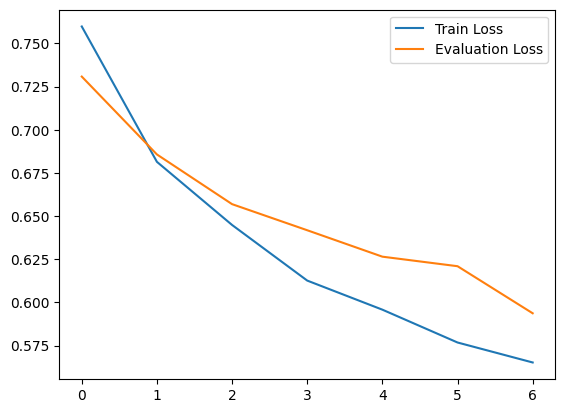

In [ ]:
lr = 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 7

# Problem 1b: Your training loop code goes here
train_loss = []
val_loss = []
for t in range(num_epochs):
  model.train()
  training_loss = 0.0 # Initialize loss
  for img, label in train_dataloader:
    # Putting image and label on GPU to process and squeeze the label
    img = img.to('cuda')
    label = label.squeeze().to('cuda')
    res = model(img)
    loss = loss_fn(res, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # Edit the training_loss
    training_loss += img.size(0) * loss.item()
  num_batches_train = len(train_dataloader.dataset)
  cur_loss = training_loss / num_batches_train
  train_loss.append(cur_loss)

  # Evaluation
  model.eval()
  eval_loss = 0.0
  with torch.no_grad():
    for img, label in val_dataloader:
      img = img.to('cuda')
      label = label.squeeze().to('cuda')
      res = model(img)
      loss = loss_fn(res, label)
      eval_loss += img.size(0) * loss.item()
    num_batches_test = len(val_dataloader.dataset)
    cur_loss = eval_loss / num_batches_test
    val_loss.append(cur_loss)
  print(f"Epoch {t+1}\n-------------------------------")
  print('Train Loss: {:.4f}'.format(train_loss[-1]))
  print('Evaluation Loss: {:.4f}'.format(val_loss[-1]))
  model_path = path + 'models/model_%d.params' %t
  torch.save(model.state_dict(), model_path)

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Evaluation Loss')
plt.legend()
plt.show()

In [ ]:
# Problem 1c: Your IoU evaluation code goes here
def compute_iou(predictor, label, num_class):
  res = []
  predictor = predictor.view(-1) # Reshape to 1d tensor
  label = label.view(-1)

  # Start from 1 to pass unlabeled class
  for i in range(1, num_class):
    # mask for predictors and labels
    mask_pred = predictor == i
    mask_label = label == i
    intersection = (mask_pred[mask_label]).long().sum().item() # Both predictor and label are equal to i
    union = mask_pred.long().sum().item() + mask_label.long().sum().item() - intersection
    if union == 0: # zero division case
      res.append(float('nan'))
    else:
      res.append(float(intersection) / float(max(union, 1)))
  return res

# Computing iou for each class
class_name = ['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground', 'road', 'sidewalk', 'parking',
         'rail track', 'building', 'wall', 'fence', 'guard rail', 'bridge', 'tunnel', 'pole', 'polegroup', 'traffic light',
         'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'caravan',
         'trailer', 'train', 'motorcycle', 'bicycle']
num_class = len(class_name)

model.load_state_dict(torch.load(path + 'models/model_6.params'))
iou = []
model.eval()
with torch.no_grad():
  for X, y in val_dataloader:
    X = X.to('cuda')
    y = y.to('cuda')
    res_model = model(X)
    pred = torch.argmax(res_model, dim=1)
    add_iou = compute_iou(pred, y, num_class)
    iou.extend(add_iou)
for i, name in enumerate(class_name):
  print("{}: {:.4f}".format(name, iou[i]))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)


unlabeled: 0.8755
ego vehicle: 0.7960
rectification border: 0.7883
out of roi: 0.0020
static: 0.0000
dynamic: 0.0000
ground: 0.8953
road: 0.5025
sidewalk: 0.0000
parking: nan
rail track: 0.7018
building: 0.1027
wall: 0.0191
fence: nan
guard rail: 0.0000
bridge: nan
tunnel: 0.0388
pole: 0.0000
polegroup: 0.0046
traffic light: 0.0917
traffic sign: 0.7914
vegetation: 0.0022
terrain: 0.6998
sky: 0.2235
person: 0.0000
rider: 0.5929
car: 0.0000
truck: 0.0500
bus: nan
caravan: nan
trailer: 0.0000
train: 0.0000
motorcycle: 0.3347
bicycle: 0.8760


<ipython-input-5-c7914830cdb9>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.LongTensor(mask)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


<Figure size 640x480 with 0 Axes>

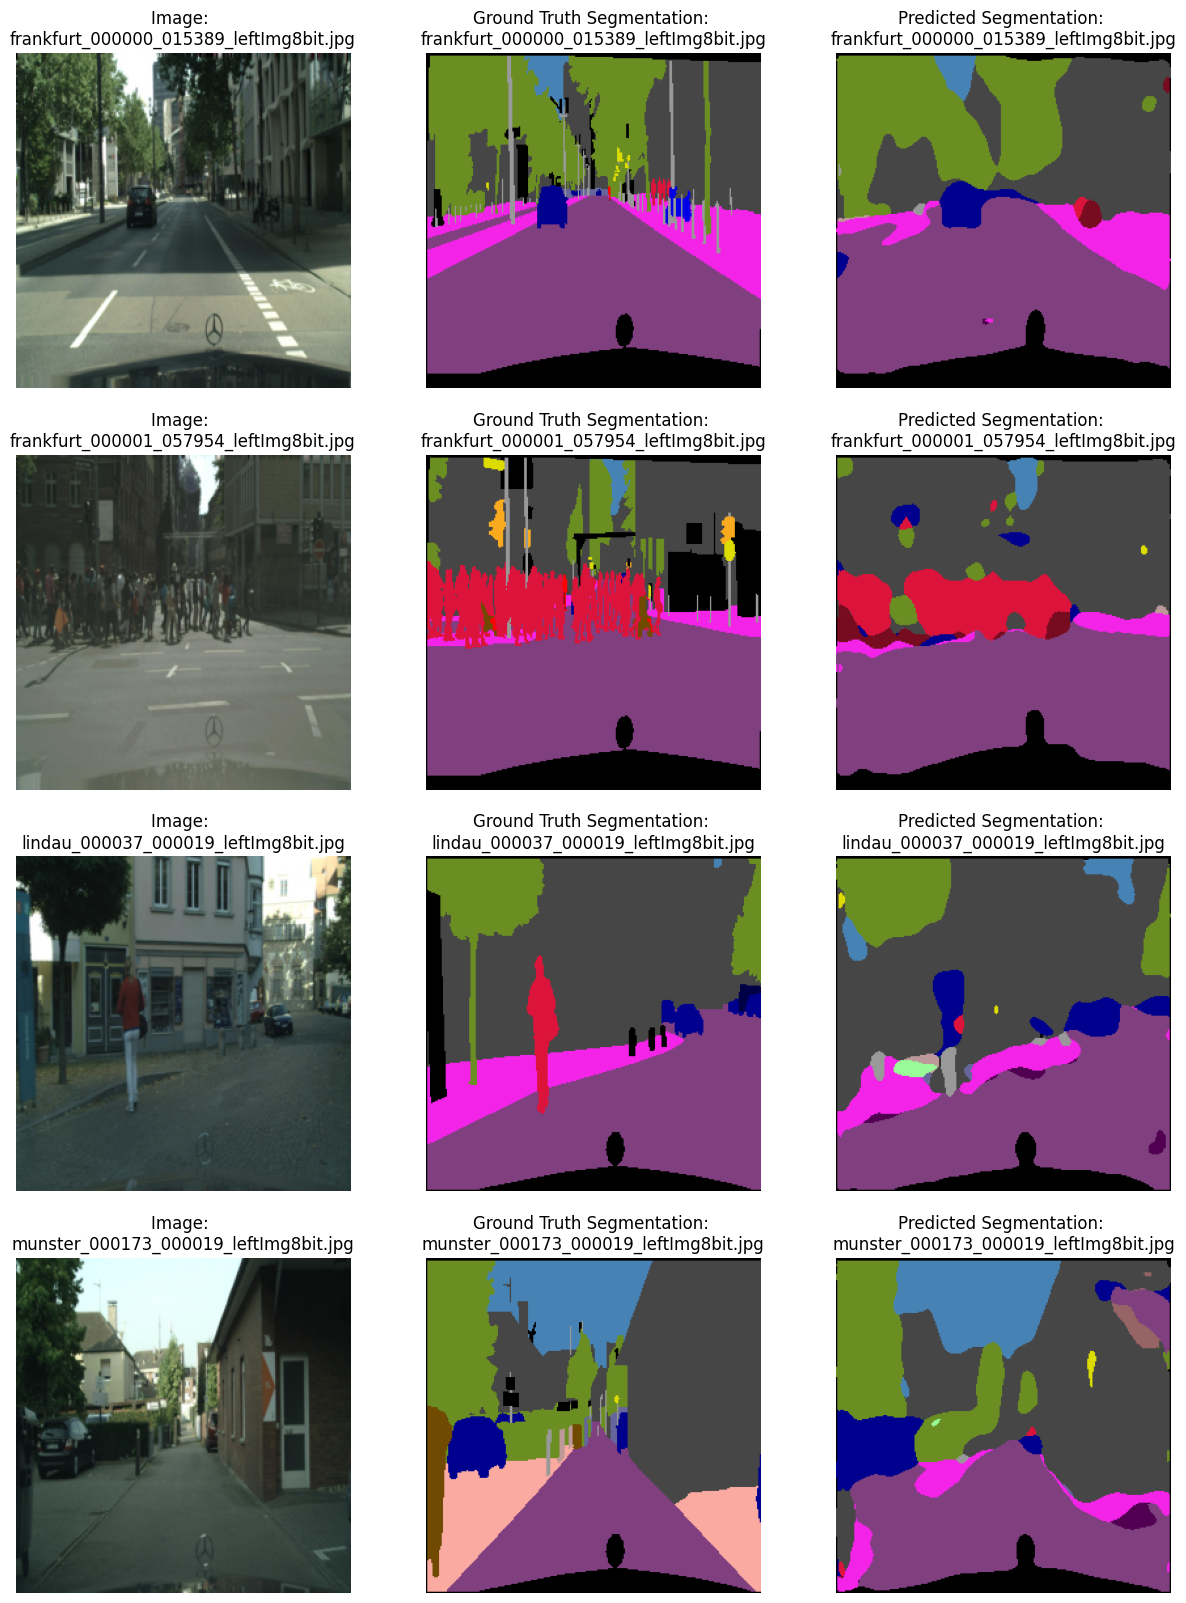

In [ ]:
# Problem 1d: Your image results code goes here
img_paths = [
    './cityscapes/val/frankfurt_000000_015389_leftImg8bit.jpg',
    './cityscapes/val/frankfurt_000001_057954_leftImg8bit.jpg',
    './cityscapes/val/lindau_000037_000019_leftImg8bit.jpg',
    './cityscapes/val/munster_000173_000019_leftImg8bit.jpg'
]

labels = [
    './cityscapes/val/frankfurt_000000_015389_gtFine_labelIds.png',
    './cityscapes/val/frankfurt_000001_057954_gtFine_labelIds.png',
    './cityscapes/val/lindau_000037_000019_gtFine_labelIds.png',
    './cityscapes/val/munster_000173_000019_gtFine_labelIds.png'
]

dataset = CityScapesDataset(img_paths, labels, im_transform, mask_transform)
test_dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

color = np.array([
    [0,   0,   0],     # Class 0: Unlabeled (Black)
    [0,   0,   0],     # Class 1: Ego Vehicle (Black)
    [0,   0,   0],     # Class 2: Rectification Border (Black)
    [0,   0,   0],     # Class 3: Out of ROI (Black)
    [0,   0,   0],     # Class 4: Static (Black)
    [111, 74,  0],     # Class 5: Dynamic (Brown)
    [81,  0,  81],     # Class 6: Ground (Purple)
    [128, 64, 128],    # Class 7: Road (Gray)
    [244, 35,  232],   # Class 8: Sidewalk (Purple-Pink)
    [250, 170, 160],   # Class 9: Parking (Light Orange)
    [230, 150, 140],   # Class 10: Rail Track (Light Pink)
    [70,  70, 70],     # Class 11: Building (Dark Gray)
    [102, 102, 156],   # Class 12: Wall (Light Blue)
    [190, 153, 153],   # Class 13: Fence (Light Gray)
    [180, 165, 180],   # Class 14: Guard Rail (Light Gray-Purple)
    [150, 100, 100],   # Class 15: Bridge (Brown)
    [150, 120, 90],    # Class 16: Tunnel (Brown)
    [153, 153, 153],   # Class 17: Pole (Light Gray)
    [153, 153, 153],   # Class 18: Polegroup (Light Gray)
    [250, 170, 30],    # Class 19: Traffic Light (Orange)
    [220, 220, 0],     # Class 20: Traffic Sign (Yellow)
    [107, 142, 35],    # Class 21: Vegetation (Olive Green)
    [152, 251, 152],   # Class 22: Terrain (Light Green)
    [70,  130, 180],   # Class 23: Sky (Steel Blue)
    [220, 20,  60],    # Class 24: Person (Crimson)
    [255, 0,   0],     # Class 25: Rider (Red)
    [0,   0,   142],   # Class 26: Car (Dark Blue)
    [0,   0,   70],    # Class 27: Truck (Dark Navy)
    [0,   60,  100],   # Class 28: Bus (Dark Teal)
    [0,   0,   90],    # Class 29: Caravan (Dark Blue)
    [0,   0,   110],   # Class 30: Trailer (Dark Blue)
    [0,   80,  100],   # Class 31: Train (Dark Teal)
    [0,   0,   230],   # Class 32: Motorcycle (Blue)
    [119, 11,  32]     # Class 33: Bicycle (Dark Red)
])

titles = ['frankfurt_000000_015389_leftImg8bit.jpg', 'frankfurt_000001_057954_leftImg8bit.jpg',
      'lindau_000037_000019_leftImg8bit.jpg', 'munster_000173_000019_leftImg8bit.jpg']

torch.manual_seed(9)
model.load_state_dict(torch.load(path + 'models/model_6.params'))
model.eval()

true_labels = []
pred_labels = []
imgs = []

for batch, (X, y) in enumerate(test_dataloader):
  X = X.to('cuda')
  y = y.to('cuda')

  # Data augmentation
  X = torch.flip(X, dims=[3])
  y = torch.flip(y, dims=[3])

  pred = model(X)
  pred = torch.argmax(pred, dim=1)

  imgs.extend(X)
  pred_labels.extend(pred.cpu().numpy())
  true_labels.extend(y.cpu().numpy())

# Plot
plt.figure()
fig, ax = plt.subplots(len(pred_labels), 3, figsize=(15, 20))
for i, (pred, true, title) in enumerate(zip(pred_labels, true_labels, titles)):
  height, width = pred.shape
  pred_seg = np.zeros((height, width, 3))
  true_seg = np.zeros((height, width, 3))

  for y in range(height):
    for x in range(width):
      # true
      r, g, b = color[int(true.squeeze(0)[y][x])]
      true_seg[y][x][0] = r
      true_seg[y][x][1] = g
      true_seg[y][x][2] = b

      # predict
      r, g, b = color[int(pred[y][x])]
      pred_seg[y][x][0] = r
      pred_seg[y][x][1] = g
      pred_seg[y][x][2] = b

  idx = len(pred_labels) - i - 1
  # Original image
  ax[i][0].set_title('Image: \n' + title)
  ax[idx][0].imshow(torch.permute(imgs[i].cpu(), (1,2,0)))
  ax[idx][0].axis('off')

  # True segmentation
  ax[i][1].set_title('Ground Truth Segmentation: \n' + title)
  ax[idx][1].imshow(true_seg.astype(np.uint8))
  ax[idx][1].axis('off')

  # Predicted segmentation
  ax[i][2].set_title('Predicted Segmentation: \n' + title)
  ax[idx][2].imshow(pred_seg.astype(np.uint8))
  ax[idx][2].axis('off')
plt.show()

# Problem 2: StyleGAN


In [ ]:
# setup correct PyTorch version
!pip install -U torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
import torch

# Download the code
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch

# install other dependencies
!pip install ninja

print('PyTorch version: {}'.format(torch.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(torch.cuda.get_device_name()))

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu110 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [ ]:
# Download the model
import argparse
import numpy as np
import PIL.Image
import dnnlib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio
import matplotlib.pyplot as plt
import legacy
import cv2
import torch
from tqdm.autonotebook import tqdm

device = torch.device('cuda')

# Choose between these pretrained models
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqcat.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqdog.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqwild.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/brecahad.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"

# If downloads fails, you can try downloading manually and uploading to the session directly
# network_pkl = "/content/ffhq.pkl"

print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as f:
  G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...

<ipython-input-2-6b27064af174>:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


 done


In [ ]:
# Useful utility functions...

# Generates an image from a style vector.
def generate_image_from_style(dlatent, noise_mode='none'):

  if len(dlatent.shape) == 1:
    dlatent = dlatent.unsqueeze(0)

  row_images = G.synthesis(dlatent, noise_mode=noise_mode)
  row_images = (row_images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return row_images[0].cpu().numpy()

# Converts a noise vector z to a style vector w.
def convert_z_to_w(latent, truncation_psi=0.7, truncation_cutoff=9, class_idx=None):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
    if class_idx is None:
      RuntimeError('Must specify class label with class_idx when using a conditional network')
    label[:, class_idx] = 1
  else:
    if class_idx is not None:
      print(f'warning: class_idx={class_idx} ignored when running on an unconditional network')
  return G.mapping(latent, label, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


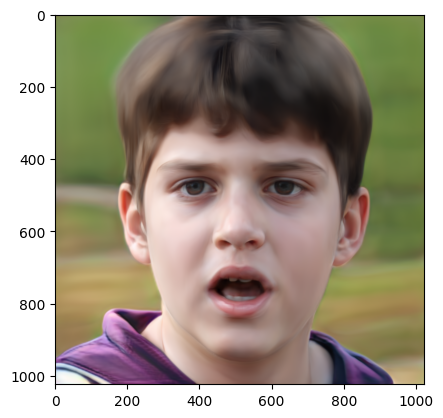

In [ ]:
# Sample code to generate images.
np.random.seed(123) # You can change this random seed.

# Generate a random noise (z) vector.
z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)

# Convert z vector to w vector.
w = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9)

# Generate and show image.
img = generate_image_from_style(w)
plt.imshow(img)

## LATENT SPACE FACE TRAVERSALS

In [ ]:
# download
!gdown "1vekENF84yvVpKhMaChqTVEyttAckZ4PU" -O "../"

Downloading...
From (original): https://drive.google.com/uc?id=1vekENF84yvVpKhMaChqTVEyttAckZ4PU
From (redirected): https://drive.google.com/uc?id=1vekENF84yvVpKhMaChqTVEyttAckZ4PU&confirm=t&uuid=90367fd1-6062-4592-8077-83b5e0be5376
To: /content/ffhq-Gender.weights
100% 94.4M/94.4M [00:02<00:00, 34.9MB/s]


In [ ]:
from torchvision import models as tv
cnn = tv.resnet50(pretrained=False, progress=True, num_classes = 1)
cnn.eval()
cnn.load_state_dict(torch.load('../ffhq-Gender.weights', map_location=lambda storage, loc: storage))

# Returns whether face is perceptually female (True) or male (False) given
# an input image of shape (H, W, 3).
def face_is_female(img):
  im = np.asarray(img)/255.0
  im = cv2.resize(im, (256, 256))
  im = np.expand_dims(np.transpose(im, (2,0,1)), 0)
  im = torch.FloatTensor(im)
  logits = cnn(im)[0, 0]
  return (logits < 0.5).numpy()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Problem 1a: Interpolation between two faces and gender classification.


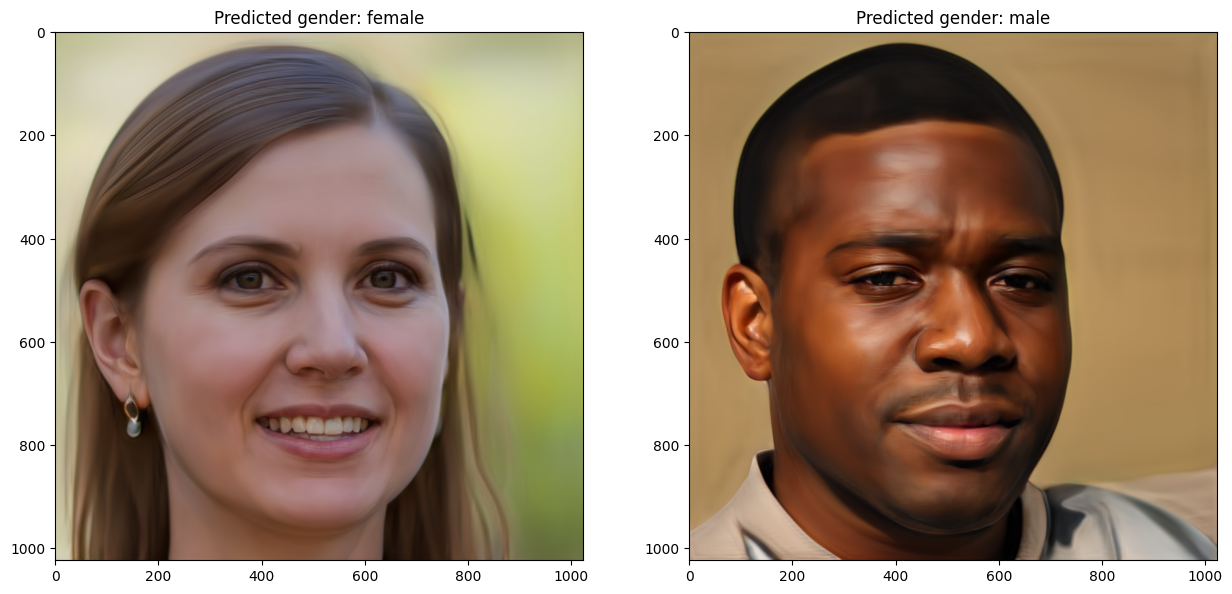

In [ ]:
# Your code goes here.
np.random.seed(120)
z0 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
z1 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)

# Convert z vector to w vector.
w0 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)
w1 = convert_z_to_w(z1, truncation_psi=0.7, truncation_cutoff=9)

# Generate and show image.
img0 = generate_image_from_style(w0)
img1 = generate_image_from_style(w1)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img0)
axes[0].set_title('Predicted gender: {}'.format('female' if face_is_female(img0) else 'male'))
axes[1].imshow(img1)
axes[1].set_title('Predicted gender: {}'.format('female' if face_is_female(img1) else 'male'))
plt.show()

i. Interpolate between the latent vectors z0 , and z1 with 5 intermediate points.

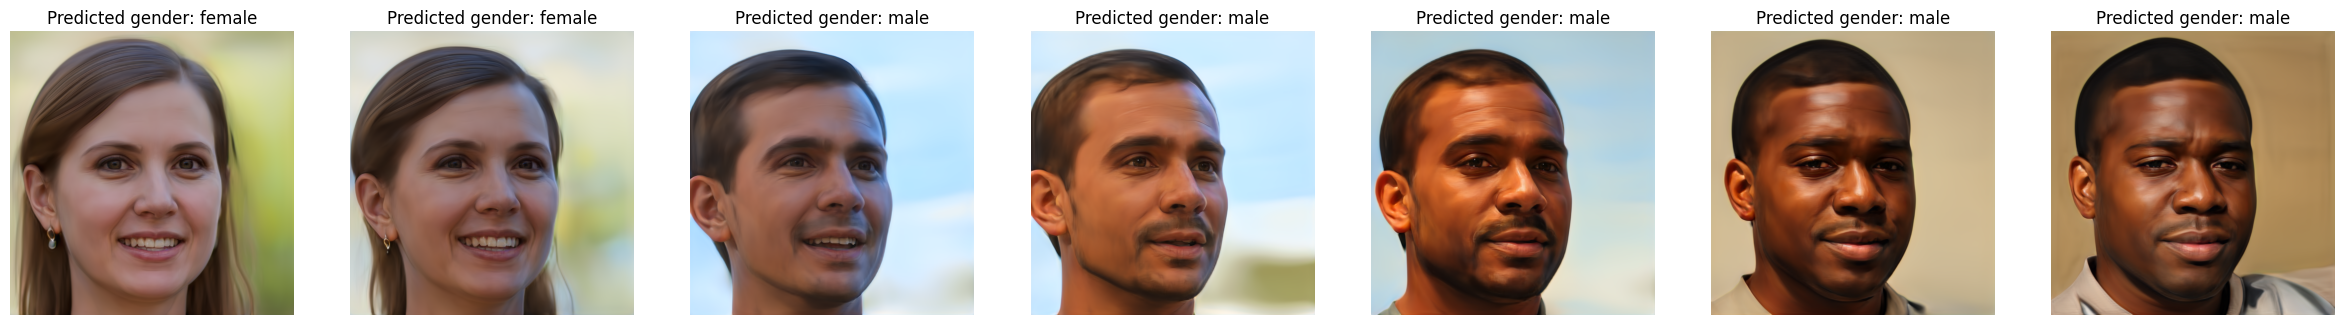

In [ ]:
diff = (z1 - z0) / 6
z_cur = z0
fig, axes = plt.subplots(1, 7, figsize = (30, 10))
axes[0].imshow(img0)
axes[0].axis(False)
axes[0].set_title('Predicted gender: {}'.format('female' if face_is_female(img0) else 'male'))
for i in range(6):
  z_cur = z_cur + diff
  w_cur = convert_z_to_w(z_cur, truncation_psi=0.7, truncation_cutoff=9)
  img = generate_image_from_style(w_cur)

  axes[i + 1].imshow(img)
  axes[i + 1].axis(False)
  axes[i + 1].set_title('Predicted gender: {}'.format('female' if face_is_female(img) else 'male'))
plt.show()

ii. Interpolate between the style vectors w0, and w1 with 5 intermediate points.

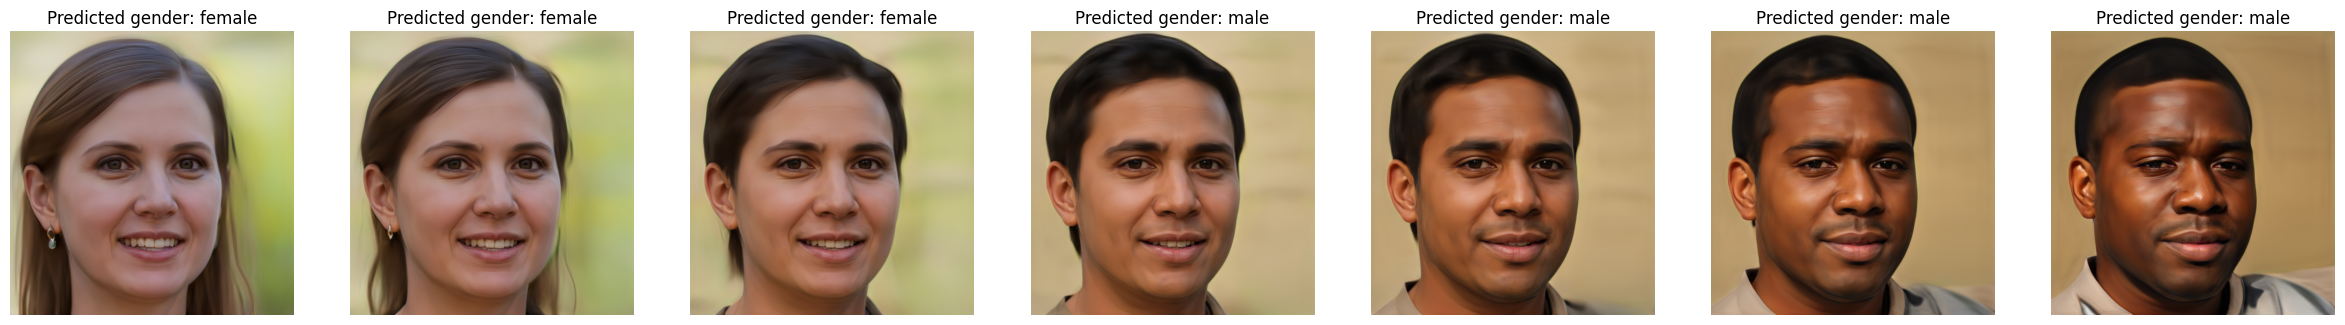

In [ ]:
diff = (w1 - w0) / 6
fig, axes = plt.subplots(1, 7, figsize = (30, 10))
axes[0].imshow(img0)
axes[0].axis(False)
axes[0].set_title('Predicted gender: {}'.format('female' if face_is_female(img0) else 'male'))
w_cur = w0
for i in range(6):
  w_cur = w_cur + diff
  img = generate_image_from_style(w_cur)

  axes[i + 1].imshow(img)
  axes[i + 1].axis(False)
  axes[i + 1].set_title('Predicted gender: {}'.format('female' if face_is_female(img) else 'male'))
plt.show()

Problem 1b: Latent space traversals

In [ ]:
# Your code goes here.
z_arr = []
w_arr = []
sex_indicator = []
for i in range(1000):
  np.random.seed(i)
  z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
  z_arr.append(z)
  w = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9)
  w_arr.append(w)
  sex_indicator.append(face_is_female(generate_image_from_style(w)))

ii. Train a linear classifier (use scikit-learn’s linear SVM) that predicts gender from the style vector.

In [ ]:
from sklearn import svm, preprocessing, pipeline
# convert cuda tensors to numpy arrays before sending to scikit-learn’s functions
w_arr = np.array([w.cpu().numpy() for w in w_arr])
w_arr = w_arr.reshape(1000, 1*18*512)
sex_indicator = np.array(sex_indicator)

linearSVM = svm.LinearSVC(random_state=0, tol=1e-5)
classifier = pipeline.make_pipeline(preprocessing.StandardScaler(), linearSVM)

classifier.fit(w_arr, sex_indicator)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

iii. Sample 2 random w vectors. For each w vector, display a strip of 5 images.

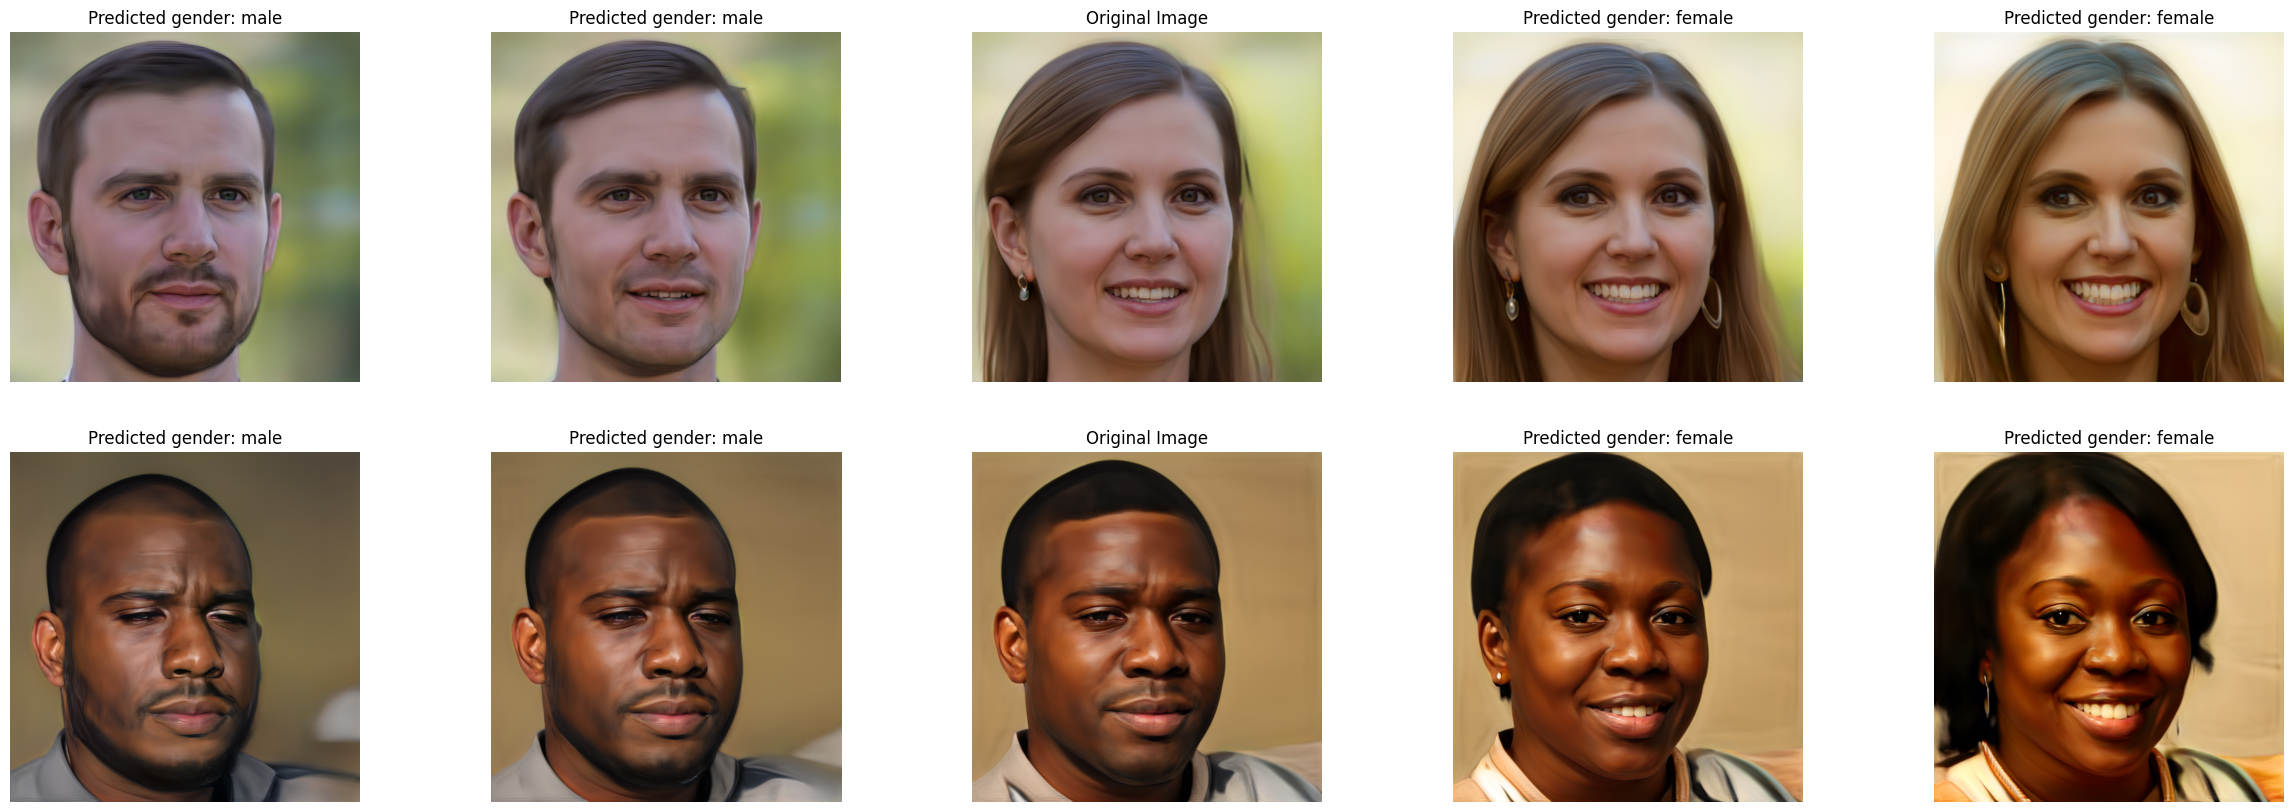

In [ ]:
# Initialize the step size
step = 30
cur_step = -2 * step

np.random.seed(120)
z0 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
z1 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)

# Convert z vector to w vector.
w0 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)
w1 = convert_z_to_w(z1, truncation_psi=0.7, truncation_cutoff=9)

coef = classifier.named_steps['linearsvc'].coef_.reshape((1, 18, 512))

# Plot
fig, axes = plt.subplots(2, 5, figsize = (30, 10))
for i in range(5):
  w0_temp = w0.cpu().numpy() + (cur_step + i * 30) * coef
  w0_temp = torch.from_numpy(w0_temp).to(device)
  img0 = generate_image_from_style(w0_temp)

  axes[0][i].imshow(img0)
  axes[0][i].axis(False)
  axes[0][i].set_title('Predicted gender: {}'.format('female' if face_is_female(img0) else 'male'))
  axes[0][2].set_title('Original Image')

  w1_temp = w1.cpu().numpy() + (cur_step + i * 30) * coef
  w1_temp = torch.from_numpy(w1_temp).to(device)
  img1 = generate_image_from_style(w1_temp)

  axes[1][i].imshow(img1)
  axes[1][i].axis(False)
  axes[1][i].set_title('Predicted gender: {}'.format('female' if face_is_female(img1) else 'male'))
  axes[1][2].set_title('Original Image')
plt.show()

# Problem 3


In [ ]:
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0m159qfg
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0m159qfg
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 672.3 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

In [ ]:
import clip

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

cifar = np.load(path + 'CIFAR.npz') # Replace with your path to CIFAR.
X,y,label_names = cifar['X'], cifar['y']*1.0, cifar['label_names']
print(label_names)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [ ]:
from tqdm import tqdm
device = torch.device('cuda')
captions = [] # Your code goes here.
# create 10 different captions
for label in label_names:
  captions.append("An image of a {}".format(label))

# Initialize the cnt
cnt = 0

# Iterate over all test examples.
for i in tqdm(range(50000, 60000)):
  image = preprocess(Image.fromarray(np.uint8(X[i,...]))).unsqueeze(0).to('cuda')
  text = clip.tokenize(captions).to(device)

  with torch.no_grad():
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # Your code goes here.
    pred = np.argmax(probs)

    # correct prediction
    if pred == y[i]:
      cnt += 1

# Your code goes here.
print("Overall Accuracy:", 100 * (cnt / 10000))

100%|██████████| 10000/10000 [03:34<00:00, 46.59it/s]

Overall Accuracy: 89.11
